<a href="https://colab.research.google.com/github/fabiomarchiano/fabiomarchiano.github.io/blob/master/DEA_MouseTC_toMean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory analysis in R + DEA for the tabula muris project

### funciton definition

In [ ]:
#MA plot definition

maplot <- function (res, thresh=FDRthreshold, labelsig=TRUE, textcx=1, ...) {
  with(res, plot(baseMean, log2FoldChange, pch=20, cex=.5, log="x", ...))
  with(subset(res, padj<thresh), points(baseMean, log2FoldChange, col="red", pch=20, cex=1.5))
  if (labelsig) {
    require(calibrate)
    with(subset(res, padj<thresh), textxy(baseMean, log2FoldChange, labs=Gene, cex=textcx, col=2))
  }
}

In [ ]:
#volcanoplot definition

volcanoplot <- function (res, lfcthresh=log2FCthreshold, sigthresh=FDRthreshold, main="Volcano Plot", legendpos="bottomright", labelsig=TRUE, textcx=1, ...) {
  with(res, plot(log2FoldChange, -log10(padj), pch=20, main=main, ...))
  with(subset(res, padj<sigthresh ), points(log2FoldChange, -log10(padj), pch=20, col="red", ...))
  with(subset(res, abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(padj), pch=20, col="orange", ...))
  with(subset(res, padj<sigthresh & abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(padj), pch=20, col="green", ...))
  if (labelsig) {
    require(calibrate)
    with(subset(res, padj<sigthresh & abs(log2FoldChange)>lfcthresh), textxy(log2FoldChange, -log10(padj), labs=Gene, cex=textcx, ...))
  }
  legend(legendpos,cex=textcx, xjust=1, yjust=1, legend=c(paste("FDR<",sigthresh,sep=""), paste("|LogFC|>",lfcthresh,sep=""), "both"), pch=20, col=c("red","orange","green"))
}

In [ ]:
#PCA definition


rld_pca <- function (rld, intgroup = "condition", ntop = 1000, colors=NULL, legendpos="bottomright", main="PCA plot", textcx=0.6, ...) {
  require(genefilter)
  require(calibrate)
  require(RColorBrewer)
  rv = rowVars(assay(rld))
  select = order(rv, decreasing = TRUE)[seq_len(min(ntop, length(rv)))]
  pca = prcomp(t(assay(rld)[select, ]))
  fac = factor(apply(as.data.frame(colData(rld)[, intgroup, drop = FALSE]), 1, paste, collapse = " : "))
  if (is.null(colors)) {
    if (nlevels(fac) >= 3) {
      colors = brewer.pal(nlevels(fac), "Paired")
    }   else {
      colors = c("black", "red")
    }
  }
  pc1var <- round(summary(pca)$importance[2,1]*100, digits=1)
  pc2var <- round(summary(pca)$importance[2,2]*100, digits=1)
  pc1lab <- paste0("PC1 (",as.character(pc1var),"%)")
  pc2lab <- paste0("PC2 (",as.character(pc2var),"%)")
    
  plot(PC2~PC1, data=as.data.frame(pca$x), bg=colors[fac], pch=21, xlab=pc1lab, ylab=pc2lab, main=main, ...)
    
  with(as.data.frame(pca$x), textxy(PC1, PC2, labs=rownames(as.data.frame(pca$x)), cex=textcx))
  legend(legendpos, legend=levels(fac), col=colors, pch=20,cex = 0.95)
  ##in case you want to include labels
  #     rldyplot(PC2 ~ PC1, groups = fac, data = as.data.frame(pca$rld),
  #            pch = 16, cerld = 2, aspect = "iso", col = colours, main = draw.key(key = list(rect = list(col = colours),
  #                                                                                         terldt = list(levels(fac)), rep = FALSE)))
}


installing all the needed packages

In [ ]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("gplots")
# BiocManager::install("parallel")
# BiocManager::install("stats4")
# BiocManager::install("BiocGenerics")
# BiocManager::install("IRanges")
# BiocManager::install("DESeq2")
# BiocManager::install("genefilter")
# BiocManager::install("calibrate")
# BiocManager::install("MASS")
# BiocManager::install("RColorBrewer")
# BiocManager::install("gplots")
# BiocManager::install("S4Vectors")

load required libraries

In [ ]:
library(parallel)
library(stats4)
library(BiocGenerics)
library(IRanges)
library(DESeq2)
library(genefilter)
library(calibrate)
library(MASS)
library(RColorBrewer)
library(gplots)
library(S4Vectors)
library(edgeR)


Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which.min

Loading required package: S4Vectors

Attaching package: ‘S4Vectors’

The following object is masked from ‘package:base’:

    expand.grid

list packages versions for reproducibility

In [ ]:
packageVersion("DESeq2")

[1] ‘1.22.2’

In [ ]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /home/fabio/.conda/envs/Marvin/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] gplots_3.0.1.1              RColorBrewer_1.1-2         
 [3] calibrate_1.7.2             MASS_7.3-51.4              
 [5] genefilter_1.64.0           DESeq2_1.22.2              
 [7] SummarizedExperiment_1.12.0 DelayedArray_0.8.0         
 [9] BiocParallel_1.16.6         matrixSta

load the raw counts from featuresCount

In [ ]:
df <- read.table("raw_counts.txt", header=TRUE, row.names =1)

In [ ]:
head(df)

,Female.17.months.1,Female.17.months.3,Female.17.months.5,Female.17.months.7,Female.24.months.1,Female.24.months.3,Female.24.months.6,Female.24.months.8,Female.3.months.2,Female.3.months.4,⋯,Male.24.months.6,Male.24.months.8,Male.3.months.1,Male.3.months.2,Male.3.months.4,Male.3.months.5,Male.9.months.1,Male.9.months.6,Male.9.months.8,Male.9.months.9
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Gm26206,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Xkr4,13,9,5,21,13,20,10,16,14,29,⋯,9,16,6,3,48,4,10,4,8,11
LOC118567655,0,0,0,0,0,0,1,1,0,0,⋯,0,0,0,0,1,0,0,0,0,0
Rp1,44,27,99,141,114,127,106,117,46,580,⋯,67,21,56,54,798,18,112,202,50,1
Sox17,182,161,205,176,133,184,128,138,192,219,⋯,164,162,235,197,274,202,200,247,183,139
Gm22307,1,0,0,0,1,0,0,1,1,1,⋯,0,7,1,0,0,2,0,0,0,1


In [ ]:
#compute means for pseudo replicates

TC$meanF1 <- round(rowMeans(TC[,c('Female.17.months.1','Female.24.months.1','Female.3.months.2','Female.9.months.3')]))
TC$meanF2 <- round(rowMeans(TC[,c('Female.17.months.3','Female.24.months.3','Female.3.months.4','Female.9.months.4')]))
TC$meanF3 <- round(rowMeans(TC[,c('Female.17.months.5','Female.24.months.6','Female.3.months.5','Female.9.months.6')]))
TC$meanF4 <- round(rowMeans(TC[,c('Female.17.months.7','Female.24.months.8','Female.3.months.6','Female.9.months.7')]))
TC$meanM1 <- round(rowMeans(TC[,c('Male.17.months.10','Male.24.months.3','Male.3.months.1','Male.9.months.1')]))
TC$meanM2 <- round(rowMeans(TC[,c('Male.17.months.3','Male.24.months.5','Male.3.months.2','Male.9.months.6')]))
TC$meanM3 <- round(rowMeans(TC[,c('Male.17.months.6','Male.24.months.6','Male.3.months.4','Male.9.months.8')]))
TC$meanM4 <- round(rowMeans(TC[,c('Male.17.months.8','Male.24.months.8','Male.3.months.5','Male.9.months.9')]))

In [ ]:
#transform in matrix

matrix <- as.matrix(TC)
head(matrix)
dim(matrix)

,Female.17.months.1,Female.17.months.3,Female.17.months.5,Female.17.months.7,Female.24.months.1,Female.24.months.3,Female.24.months.6,Female.24.months.8,Female.3.months.2,Female.3.months.4,⋯,Male.9.months.8,Male.9.months.9,meanF1,meanF2,meanF3,meanF4,meanM1,meanM2,meanM3,meanM4
Gm26206,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Xkr4,13,9,5,21,13,20,10,16,14,29,⋯,8,11,14,16,10,20,7,12,18,10
LOC118567655,0,0,0,0,0,0,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Rp1,44,27,99,141,114,127,106,117,46,580,⋯,50,1,68,187,440,178,70,96,234,34
Sox17,182,161,205,176,133,184,128,138,192,219,⋯,183,139,177,173,216,180,198,212,189,174
Gm22307,1,0,0,0,1,0,0,1,1,1,⋯,0,1,1,0,1,0,0,1,0,3


[1] 40840    40

In [ ]:
# create coldata for the condition definition

cond <- cbind(c('Female.17.months.1','Female.17.months.3','Female.17.months.5','Female.17.months.7',
'Female.24.months.1','Female.24.months.3','Female.24.months.6','Female.24.months.8',
'Female.3.months.2','Female.3.months.4','Female.3.months.5','Female.3.months.6',
'Female.9.months.3','Female.9.months.4','Female.9.months.6','Female.9.months.7',
'Male.17.months.10','Male.17.months.3','Male.17.months.6','Male.17.months.8',
'Male.24.months.3','Male.24.months.5','Male.24.months.6','Male.24.months.8',
'Male.3.months.1','Male.3.months.2','Male.3.months.4','Male.3.months.5',
'Male.9.months.1','Male.9.months.6','Male.9.months.8','Male.9.months.9','meanF1','meanF2','meanF3','meanF4','meanM1','meanM2','meanM3','meanM4'),
c(rep("17months",4),rep("24months",4),rep("3months",4),rep("9months",4),
rep("17months",4),rep("24months",4),rep("3months",4),rep("9months",4),rep("baseline",8)),
c(rep("Female",4),rep("Female",4),rep("Female",4),rep("Female",4),rep("Male",4),rep("Male",4),rep("Male",4),rep("Male",4),rep("Female",4),rep("Male",4)))

colnames(cond) = c('Name', 'cond','sex')
row.names(cond) = colnames(matrix)
colData = as.data.frame(cond)
colData

,Name,cond,sex
,<fct>,<fct>,<fct>
Female.17.months.1,Female.17.months.1,17months,Female
Female.17.months.3,Female.17.months.3,17months,Female
Female.17.months.5,Female.17.months.5,17months,Female
Female.17.months.7,Female.17.months.7,17months,Female
Female.24.months.1,Female.24.months.1,24months,Female
Female.24.months.3,Female.24.months.3,24months,Female
Female.24.months.6,Female.24.months.6,24months,Female
Female.24.months.8,Female.24.months.8,24months,Female
Female.3.months.2,Female.3.months.2,3months,Female


# run the pipeline


In [ ]:
#create deseq object

dds <- DESeqDataSetFromMatrix(countData=matrix, colData=colData, design= ~sex + cond)

converting counts to integer mode


In [ ]:
#run deseq2

dds <- DESeq(dds)
dds

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


class: DESeqDataSet 
dim: 40840 40 
metadata(1): version
assays(4): counts mu H cooks
rownames(40840): Gm26206 Xkr4 ... TrnT TrnP
rowData names(38): baseMean baseVar ... deviance maxCooks
colnames(40): Female.17.months.1 Female.17.months.3 ... meanM3 meanM4
colData names(4): Name cond sex sizeFactor

# exploratory analysis



In [ ]:
#transformation of the results in log scale

rlog <- rlog(dds)
head(assay(rlog))

rlog() may take a few minutes with 30 or more samples,
vst() is a much faster transformation


,Female.17.months.1,Female.17.months.3,Female.17.months.5,Female.17.months.7,Female.24.months.1,Female.24.months.3,Female.24.months.6,Female.24.months.8,Female.3.months.2,Female.3.months.4,⋯,Male.9.months.8,Male.9.months.9,meanF1,meanF2,meanF3,meanF4,meanM1,meanM2,meanM3,meanM4
Gm26206,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.0000000,0.0000000,⋯,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
Xkr4,3.7109362,3.5226719,3.4188060,3.8541743,3.6356244,3.7999353,3.5612319,3.698901,3.6219739,3.9750058,⋯,3.4967532,3.5914683,3.6604996,3.6971660,3.5637799,3.8241688,3.4548768,3.5809242,3.7736996,3.5471245
LOC118567655,-2.0865378,-2.0877265,-2.0868894,-2.0876985,-2.0878714,-2.0881490,-2.0743570,-2.074956,-2.0886097,-2.0884003,⋯,-2.0875827,-2.0875973,-2.0879268,-2.0882116,-2.0875325,-2.0877866,-2.0877751,-2.0883615,-2.0878018,-2.0878691
Rp1,6.1215900,5.6982624,6.7227292,6.9352882,6.7176227,6.7773942,6.6912766,6.699225,5.9198756,8.2744641,⋯,6.0918254,5.0509942,6.2787317,7.1319189,8.1139033,7.1448589,6.3198267,6.5041243,7.4132152,5.8116334
Sox17,7.6880061,7.4156783,7.7495935,7.4983843,7.2326963,7.4770988,7.2376949,7.223464,7.4527557,7.6002940,⋯,7.5491889,7.3055797,7.4725579,7.4140169,7.7082815,7.5065535,7.5943511,7.5759396,7.5484184,7.4651374
Gm22307,-0.3313084,-0.3824136,-0.3808445,-0.3823619,-0.3394784,-0.3831857,-0.3821496,-0.341323,-0.3438093,-0.3425966,⋯,-0.3821477,-0.3378331,-0.3398086,-0.3832988,-0.3374416,-0.3825244,-0.3825032,-0.3423707,-0.3825523,-0.2577934


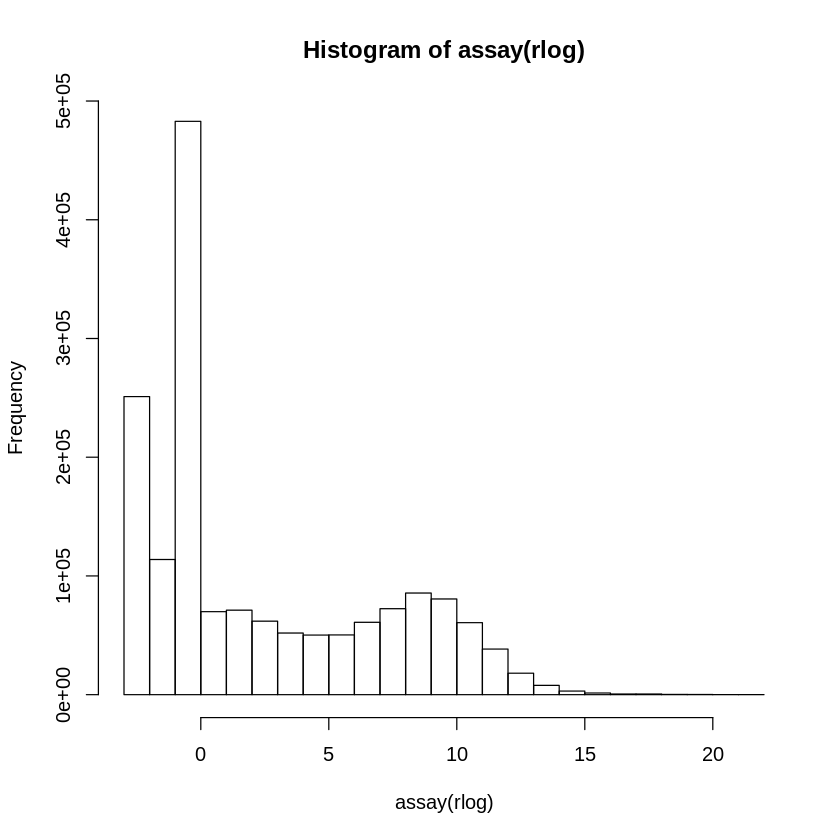

In [ ]:
#check reads distribution

hist(assay(rlog))

Generate a Dispersion Plot (DESeq2 uses shrinkage estimation for dispersions and fold changes to improve stability and interpretability of the estimates)

png 
  2

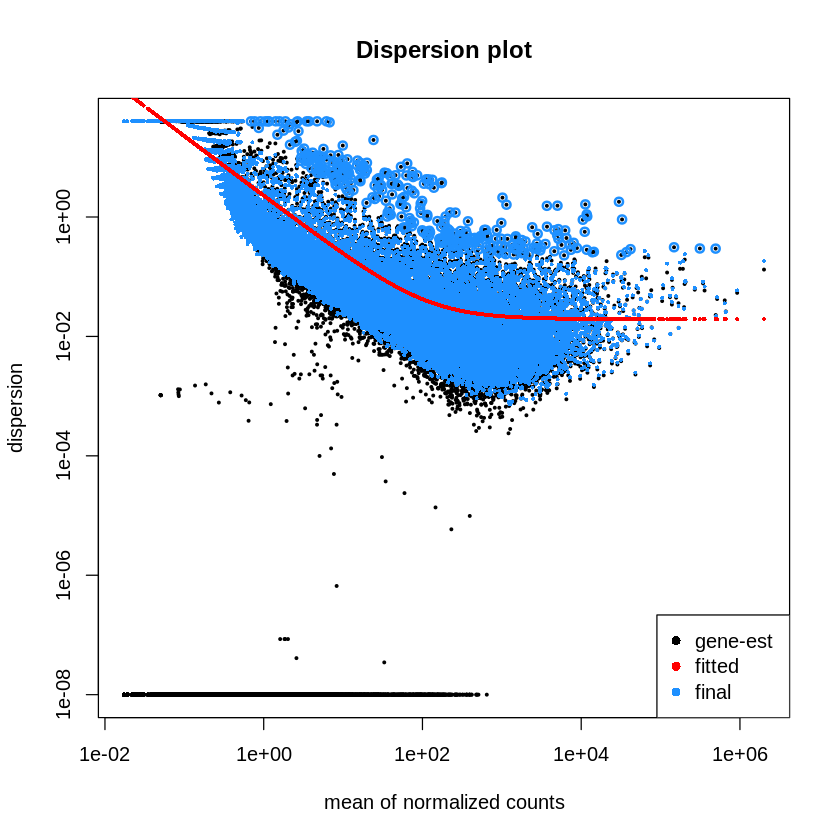

In [ ]:
plotDispEsts(dds, main="Dispersion plot")#visualize the png

In [ ]:
#pearson correlation among samples

write.csv(cor(assay(rlog),method = "pearson"),"pearson.csv")

In [ ]:
#colour definition for the heatmaps

mycols <- c(rep("dodgerblue",4),rep("firebrick",4),rep("forestgreen",4),rep("gold",4),rep("dodgerblue",4),rep("firebrick",4),rep("forestgreen",4),rep("gold",4),rep("#BAE1FF",4),rep("#BAE1FF",4))

In [ ]:
#we wont shorter names for our plots otherwise wont be readable :)

newnames = c('F_17m_1','F_17m_3','F_17m_5','F_17m_7',
'F_24m_1','F_24m_3','F_24m_6','F_24m_8',
'F_3m_2','F_3m_4','F_3m_5','F_3m_6',
'F_9m_3','F_9m_4','F_9m_6','F_9m_7',
'M_17m_10','M_17m_3','M_17m_6','M_17m_8',
'M_24m_3','M_24m_5','M_24m_6','M_24m_8',
'M_3m_1','M_3m_2','M_3m_4','M_3m_5',
'M_9m_1','M_9m_6','M_9m_8','M_9m_9',
'meanF1','meanF2','meanF3','meanF4',
'meanM1','meanM2','meanM3','meanM4')

In [ ]:
boxplot(assay(rlog),notch=TRUE, main= "Read count distribution", ylab="Trasformed (rlog) read count", las=2 , col= mycols,
names=newnames)

png 
  2

In [ ]:
#distances among samples and new names assignment
sampleDists <- as.matrix(dist(t(assay(rlog))))
row.names(sampleDists) <- newnames
colnames(sampleDists) <- newnames

#draw heatmap
heatmap.2(sampleDists, key=F, trace="none",
          col=colorpanel(100, "black", "white"),
          ColSideColors=mycols, 
          RowSideColors=mycols,
          margin=c(10, 10), main="Sample Distance Matrix")

png 
  2

In [ ]:
#draw the PCA

colnames(rlog) <- newnames
rld_pca(rlog, colors = c("dodgerblue","firebrick","forestgreen","gold","#BAE1FF"), intgroup="cond",xlim=c(-30, 60),ylim=c(-30,15))

png 
  2

In [ ]:
#write normalized counts and transformed counts for downstream analysis (es clustering)

write.csv( counts(dds, normalized=TRUE), '/home/fabio/Documents/Tristan/TC/toMean/normalized_counts.csv' ) # normalized counts
write.csv( assay(rlog), '/home/fabio/Documents/Tristan/TC/toMean/transformed_counts.csv' )

# Pairwise comparisons

In [ ]:
comparisons<- c('24months_VS_baseline','17months_VS_baseline','9months_VS_baseline','3months_VS_baseline')

In [ ]:
dir <- "yourPath"

In [ ]:
#define your cutoffs for the 

log2FCthreshold<-1
FDRthreshold<-0.05

In [ ]:
#this you can download it from MitoX2 : http://mitoxplorer2.ibdm.univ-mrs.fr/interactome.php

interactome <- read.table("Mouse_Interactome.tsv", sep = '\t', header = TRUE)
colnames(interactome)[1]<-"Gene"

In [ ]:
for (dirname in comparisons){
  dir.create(paste(dir, dirname, sep=""))
  #set working directory
  setwd(paste(dir,dirname, sep=""))

  #choose the contrast
  first <- strsplit(dirname, "_VS_")[[1]][1]
  second <- strsplit(dirname, "_VS_")[[1]][2]
  res <- results(dds,c('cond',first, second))

  ##############table(res$padj<0.05)

  ## Order by adjusted p-value
  res <- res[order(res$padj), ]

  ## Merge with normalized count data
  resdata <- merge(as.data.frame(res), as.data.frame(counts(dds, normalized=TRUE)), by="row.names", sort=FALSE)
  #compute the mean for condition
  resdata[paste("Mean_",second, sep="")]<-rowMeans(resdata[,as.character(colData[colData$cond==second, "Name"])])
  resdata[paste("Mean_", first,sep="")]<-rowMeans(resdata[,as.character(colData[colData$cond==first, "Name"])])
  colnames(resdata)[1]<-"Gene"
  #create interactome dataset
  interactomeanno <- merge(interactome,resdata,by="Gene", all.x = TRUE)
  interactomeannoFilt <-subset(interactomeanno, interactomeanno$padj<FDRthreshold)
  #Give to the first colun with the IDs the name Gene

  #plot of p-values
  png("Hist-PValues.png")
  hist(res$pvalue, breaks=50, col="grey")
  dev.off()

  #i redifined the funciton here to change behaviour in according the change of the cutoffs..not the samrtest thing to do :) i will modify the functions instead when i will have time
  #MA plot

  maplot <- function (res, thresh=FDRthreshold, labelsig=TRUE, textcx=1, ...) {
    with(res, plot(baseMean, log2FoldChange, pch=20, cex=.5, log="x", ...))
    with(subset(res, padj<thresh), points(baseMean, log2FoldChange, col="red", pch=20, cex=1.5))
    if (labelsig) {
      require(calibrate)
      with(subset(res, padj<thresh), textxy(baseMean, log2FoldChange, labs=Gene, cex=textcx, col=2))
    }
  }
      
  png("diffexpr-maplot.png", 1500, 1500, pointsize=20)
  maplot(resdata, main="MA Plot", ylim=c(-8,15))
  dev.off()

  # **Volcano plot** with "significant" genes labeled

  volcanoplot <- function (res, lfcthresh=log2FCthreshold, sigthresh=FDRthreshold, main="Volcano Plot", legendpos="bottomright", labelsig=TRUE, textcx=1, ...) {
    with(res, plot(log2FoldChange, -log10(padj), pch=20, main=main, ...))
    with(subset(res, padj<sigthresh ), points(log2FoldChange, -log10(padj), pch=20, col="red", ...))
    with(subset(res, abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(padj), pch=20, col="orange", ...))
    with(subset(res, padj<sigthresh & abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(padj), pch=20, col="green", ...))
    if (labelsig) {
      require(calibrate)
      with(subset(res, padj<sigthresh & abs(log2FoldChange)>lfcthresh), textxy(log2FoldChange, -log10(padj), labs=Gene, cex=textcx, ...))
    }
    legend(legendpos, xjust=1, yjust=1, legend=c(paste("FDR<",sigthresh,sep=""), paste("|LogFC|>",lfcthresh,sep=""), "both"), pch=20, col=c("red","orange","green"))
  }
  # plot volcano plots
  png(filename = "diffexpr-volcanoplot.png", 1200, 1000, pointsize=20)
  volcanoplot(resdata, lfcthresh=log2FCthreshold, sigthresh=FDRthreshold, textcx=.3, xlim=c(-10.3, 12) , ylim=c(0,20))
  dev.off()
      
  names(resdata)[1] <- "Gene"
  names(interactomeanno)[1] <- "Gene"

  #filtering for FDR and log2FC
  subset1 <- subset(resdata, resdata$padj<FDRthreshold)
  subset2 <- subset(subset1, subset1$log2FoldChange>log2FCthreshold | subset1$log2FoldChange <(-log2FCthreshold))

  #write all the tables we need
  write.table(interactomeanno, file = paste("interactomeanno_",dim(interactomeanno)[1],"_.txt", sep=""), sep= "\t", row.names = FALSE, quote= FALSE) 
  write.table(interactomeannoFilt, file = paste("interactomeanno_FDR",FDRthreshold,'-results_',dim(interactomeannoFilt)[1],"_.txt", sep=""), sep= "\t", row.names = FALSE, quote= FALSE) 
  write.table(subset2, file = paste("diffexpr(LFC",log2FCthreshold,",FDR",FDRthreshold,")-results_",dim(subset2)[1],"_.txt", sep=""), sep= "\t", row.names = FALSE,quote= FALSE)
  write.table(resdata, file = paste("complete-results_",dim(resdata)[1],"_.txt", sep=""), sep= "\t", row.names = FALSE, quote= FALSE)    

  #prepare tables directly for upload on mitox
  resdata["dataset"]= dirname
  write.table(resdata[,c("dataset","Gene","log2FoldChange")], file = paste("mitox_",dirname,"_.csv", sep=""), sep= ",", row.names = FALSE, quote= FALSE) 
}

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“10374 x values <= 0 omitted from logarithmic plot”Warning message in xy.coords(x, y, xlabel, ylabel, log):
“10374 x values <= 0 omitted from logarithmic plot”Warning message in xy.coords(x, y, xlabel, ylabel, log):
“10374 x values <= 0 omitted from logarithmic plot”Warning message in xy.coords(x, y, xlabel, ylabel, log):
“10374 x values <= 0 omitted from logarithmic plot”